In [3]:
from molmap.model import RegressionEstimator, MultiClassEstimator, MultiLabelEstimator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from chembench import dataset
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from molmap import MolMap
from molmap import feature

def Rdsplit(df, random_state = 888, split_size = [0.8, 0.1, 0.1]):
    base_indices = np.arange(len(df)) 
    base_indices = shuffle(base_indices, random_state = random_state) 
    nb_test = int(len(base_indices) * split_size[2]) 
    nb_val = int(len(base_indices) * split_size[1]) 
    test_idx = base_indices[0:nb_test] 
    valid_idx = base_indices[(nb_test):(nb_test+nb_val)] 
    train_idx = base_indices[(nb_test+nb_val):len(base_indices)] 
    print(len(train_idx), len(valid_idx), len(test_idx)) 
    return train_idx, valid_idx, test_idx 

In [19]:
data = dataset.load_FreeSolv()

total samples: 642


## Pre-fit your molmap object 

In [20]:
mp1 = MolMap(ftype='descriptor',metric='cosine',)
mp1.fit(verbose=0, method='umap', min_dist=0.1, n_neighbors=15,)

2021-04-24 09:25:20,379 - INFO - [bidd-molmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2021-04-24 09:25:23,824 - INFO - [bidd-molmap] - Finished


In [21]:
bitsinfo = feature.fingerprint.Extraction().bitsinfo
flist = bitsinfo[bitsinfo.Subtypes.isin(['PubChemFP', 'MACCSFP', 'PharmacoErGFP'])].IDs.tolist()
mp2 = MolMap(ftype = 'fingerprint', fmap_type = 'scatter', flist = flist) # 
mp2.fit(method = 'umap',  min_dist = 0.1, n_neighbors = 15, verbose = 0)

2021-04-24 09:25:30,078 - INFO - [bidd-molmap] - Applying naive scatter feature map...
2021-04-24 09:25:30,091 - INFO - [bidd-molmap] - Finished


## Extract Fmaps 

In [22]:
X1 = mp1.batch_transform(data.x)
X2 = mp2.batch_transform(data.x)

100%|##########| 642/642 [00:15<00:00, 42.70it/s]


In [23]:
Y = data.y

In [34]:
train_idx, valid_idx, test_idx  = Rdsplit(data.df, random_state = 123)
trainX = (X1[train_idx], X2[train_idx])
validX = (X1[valid_idx], X2[valid_idx])
testX = (X1[test_idx], X2[test_idx])

trainY = Y[train_idx]
validY = Y[valid_idx]
testY = Y[test_idx]

514 64 64


In [35]:
# define your model
clf = RegressionEstimator(n_outputs=trainY.shape[1], 
                          fmap_shape1 = X1.shape[1:], 
                          fmap_shape2 = X2.shape[1:], 
                          dense_layers = [128, 64],  
                          batch_size = 8,
                          y_scale= None, 
                          patience = 20, 
                          gpuid = 1) 

RegressionEstimator(batch_size=8, gpuid='1', patience=20)


In [36]:
# fit your model
clf.fit(trainX, trainY, validX, validY)

epoch: 0001, loss: 13.8617 - val_loss: 15.1367; rmse: 3.2234 - rmse_val: 3.8906;  r2: 0.3530 - r2_val: 0.3762                                                                                                    
epoch: 0002, loss: 9.3695 - val_loss: 13.0674; rmse: 2.8872 - rmse_val: 3.6149;  r2: 0.4721 - r2_val: 0.5376                                                                                                    
epoch: 0003, loss: 7.3868 - val_loss: 8.6541; rmse: 2.5625 - rmse_val: 2.9418;  r2: 0.5610 - r2_val: 0.6198                                                                                                    
epoch: 0004, loss: 6.1718 - val_loss: 8.8342; rmse: 2.3750 - rmse_val: 2.9722;  r2: 0.6604 - r2_val: 0.7268                                                                                                    
epoch: 0005, loss: 4.7084 - val_loss: 6.9537; rmse: 2.0999 - rmse_val: 2.6370;  r2: 0.7247 - r2_val: 0.7680                                                          

RegressionEstimator(batch_size=8, gpuid='1', patience=20)

<AxesSubplot:>

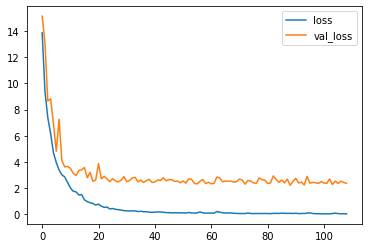

In [37]:
pd.DataFrame(clf.history.history).plot()

In [38]:
print('Best epochs: %.2f, Best MSE: %.2f' % (clf._performance.best_epoch, clf._performance.best))

Best epochs: 88.00, Best MSE: 2.21


In [39]:
testY_pred = clf.predict(testX)

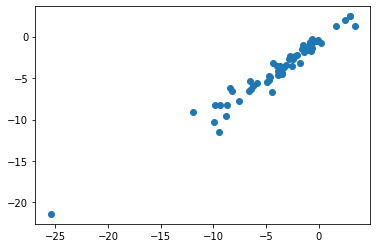

In [40]:
plt.scatter(testY, testY_pred)

In [41]:
rmse, r2 = clf._performance.evaluate(testX, testY)
rmse, r2

([1.0223323280586794], [0.956456929512906])

In [42]:
clf.score(testX, testY)

0.956456929512906

In [43]:
clf._performance.evaluate(validX, validY)

([1.4882163864453275], [0.8954233564216337])